# Consistent Bayes: Some Motivating Examples
---

Copyright 2017-2018 Michael Pilosov


### Import Libraries
_tested on 3.6 01/23/18_

In [17]:
# Mathematics and Plotting
from HelperFuns import * # pyplot wrapper functions useful for visualizations, numpy, scipy, etc.
%matplotlib inline
plt.rcParams.update({'font.size': 14})
plt.rcParams['figure.figsize'] = 5, 5
import cbayes


# Interactivity
from ipywidgets import *


---

Some introductory text goes here.   
Define $\Lambda$, $\mathcal{D}$.


--- 

## Sample from $\Lambda$
_Here we implement uniform random priors on the unit hypercube, but you can load in any set of samples in its place._

In [37]:
input_dim = 5 # Specify input space dimension (n)
num_samples = int(1E4) # number of input samples (N)
s_set = cbayes.sample.sample_set(size=(num_samples, input_dim))
s_set.set_dist('uniform')
s_set.generate_samples()
lam = s_set.samples.transpose()
# lam = np.random.uniform( size = (int(input_dim), int(num_samples)) ) # generate samples

---
## Define Parameter to Observables (PtO) Map
_ Choose from one of the following example options, feel free to add your own _ 

$O_1(\lambda) = (\lambda_1\times \frac{1}{2})$  

$O_2(\lambda) = \sum_{i=1}^n \lambda_i$  

$O_3(\lambda) = \lbrace \lambda_0 - \lambda_1, \; \;\lambda_1\rbrace$ 

$O_4(\lambda) = \lbrace \lambda_0+\lambda_1, \; \lambda_2, \; \lambda_3-\lambda_4 \rbrace$  

In [38]:
def PtO_fun1(lam): # pull first element
    return np.array([ 2*lam[0,:] ])

def PtO_fun2(lam): # sum all elements
    return np.array([ np.sum(lam,axis=0) ])

def PtO_fun3(lam): # pull two elements
    return np.array([ lam[0,:] - lam[1,:], lam[1,:] ])

def PtO_fun4(lam): # three elements
    return np.array([ lam[0,:]+lam[1,:], lam[2,:], lam[3,:]-lam[4,:] ])

In [39]:
PtO_fun_choice = 4

if PtO_fun_choice == 1:
    PtO_fun = PtO_fun1
elif PtO_fun_choice == 2:
    PtO_fun = PtO_fun2
elif PtO_fun_choice == 3:
    PtO_fun = PtO_fun3
elif PtO_fun_choice == 4:
    PtO_fun = PtO_fun4
else:
    raise( ValueError('Specify Proper PtO choice!') )

---
## Compute Data Space $O(\Lambda) = \mathcal{D}$ 

Format: `(n_dims, n_samples)`  
_Optional_: Specify subset of PtO map's components to use for inversion using the variable `sub_indices` 

In [40]:
D_full = PtO_fun(lam)
sub_indices = None
if sub_indices is not None:
    D = D_full[sub_indices,:]
else:
    D = D_full
output_dim = D.shape[0]
print('dimensions :  lambda = '+str(lam.shape)+'   D = '+str(D.shape)+'   D_full = '+str(D_full.shape) )

dimensions :  lambda = (5, 10000)   D = (3, 10000)   D_full = (3, 10000)


## Compute Push-Forward of the Prior $P_{O(\Lambda)}$
_ ... i.e. Visualize the Data Space_

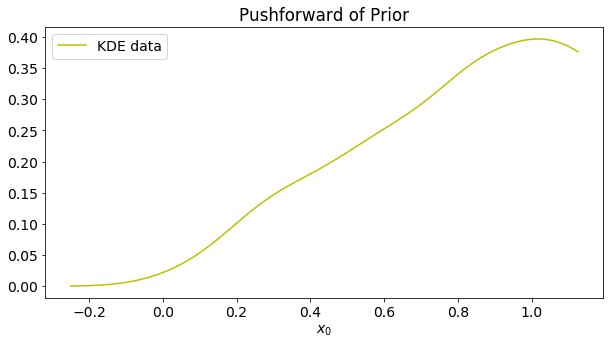

In [41]:
# # Below you will find one-dimensional histogram option
# M = 100 # number of bins in the data space
# plt.hist(D[0],M)
# plt.title('histogram of data space')
# plt.show()

# Interactive Marginal Visualization
pf_dens = gkde(D) # compute KDE estimate of it
# Can plot "slices" of densities to observe differences between posterior and prior, but not that useful

a, b = -0.25, 1.125 # linspace parameters for plotting
plot_grid = np.linspace(a, b, 100)

interact(view_est_dens, x = fixed(plot_grid), 
         estimated_dens = fixed(pf_dens), 
         lab = fixed('KDE data'), title=fixed('Pushforward of Prior'),
         viewdim=(0, output_dim-1, 1) )
plt.show()

## Define Observed Probability Measure $P_\mathcal{D}$

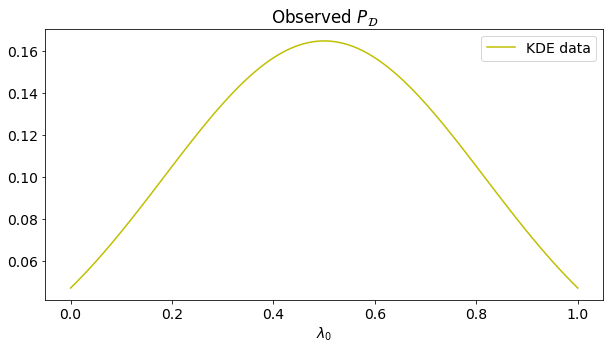

In [42]:
# We will use multivariate normals because of their common scipy.stats call syntaxes.
var_const = 0.1 # constant variance for simplicity
cov_matrix = var_const*np.eye(output_dim) # if you want non-constant, use code snippet below
# cov_matrix = np.diag( np.round(np.random.rand(1,output_dim),2)[0] ) # random independent covariances
means = np.zeros(output_dim) + 0.5 # observed density center (maximum)
obs_dens = sstats.multivariate_normal(mean = means, cov = cov_matrix )

# # For the 1-dimensional case, we can utilize the uniform density given below
# # TODO: generalize uniform box to n-dimensional case
# uni_max = 0.5
# obs_dens = sstats.uniform(0,uni_max) # 1D only

a, b = 0, 1 # linspace parameters for plotting
plot_grid = np.linspace(a, b, 100)

interact(view_analytical_dens, x = fixed(plot_grid), 
         analytical_dens = fixed(obs_dens), 
         lab = fixed('KDE data'), title=fixed('Observed $P_\mathcal{D}$'),
         viewdim=(0, output_dim-1, 1) )
plt.show()

---

At this point we have performed the computations we need to. We have evaluated the input points through our map and performed a KDE on them. It would be useful at this point to save this object and/or its evaluation at every point in the data space for later re-use. Doing so here would be an appropriate place. 

--- 

## Accept/Reject Sampling of Posterior

Since we have already used the samples in our prior to compute the pushforward density, we can re-use these with an accept/reject algorithm to get a set of samples generated from the posterior according to the solution of the stochastic inverse problem as outlined in the Consistent Bayes formulation. 

In [43]:
accept_inds = []
# the transpose below is how analytical densities take their arguments. KDE objects do not require transpose.
r = obs_dens.pdf( D.transpose() ) / pf_dens.evaluate(D) # vector of ratios evaluated at all the O(lambda)'s
M = np.max(r)
eta_r = r/M

In [44]:
accept_inds = [i for i in range(num_samples) if eta_r[i] > np.random.uniform(0,1) ]
lam_accept = np.array([lam[i,accept_inds] for i in range(input_dim)])
num_accept = len(accept_inds)
print('Number accepted: %d = %2.2f%%'%(num_accept, 100*np.float(num_accept)/num_samples))

Number accepted: 396 = 3.96%


### Visualize Accept/Reject Samples

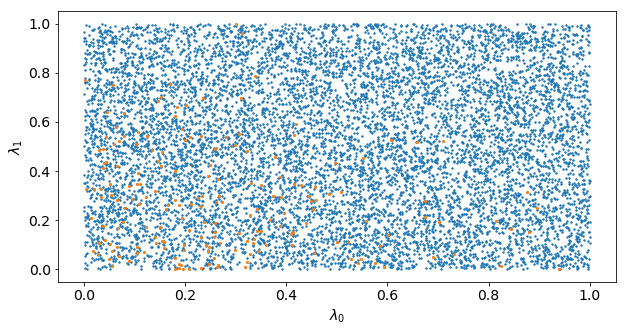

In [45]:
plt.rcParams['figure.figsize'] = 10, 5
interact(pltaccept, lam = fixed(lam), lam_accept = fixed(lam_accept), 
         N = (1, num_accept+1, 10), eta_r = fixed(eta_r), 
         i = (0, input_dim-1, 1), j = (0, input_dim-1, 1))
# You will visualize the accepted samples in a subset of size N of the input samples
plt.show()

---
## Visualize Posterior Density

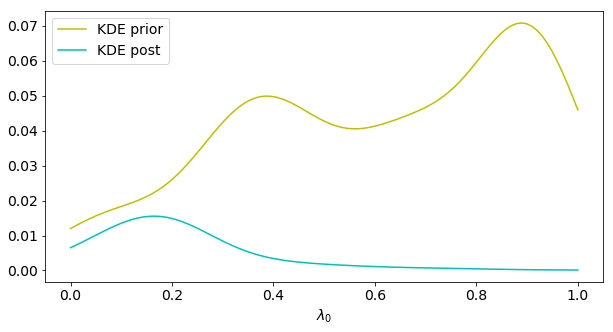

In [46]:
prior_dens_kde = gkde(lam)
post_dens_kde = gkde(lam_accept)

a, b = 0, 1 # linspace parameters for plotting
plot_grid = np.linspace(a, b, 100)

# Can plot "slices" of densities to observe differences between posterior and prior, but not that useful
interact(compare_est_input_dens, x = fixed(plot_grid), 
         estimated_dens1 = fixed(prior_dens_kde), estimated_dens2 = fixed(post_dens_kde), 
         lab_1 = fixed('KDE prior'), lab_2 = fixed('KDE post'), title=fixed(''),
         viewdim=(0, input_dim-1, 1))
plt.show()

## Visualize Quality of Solution 
_We compare the push-forward of the posterior using accepted samples against the observed density_

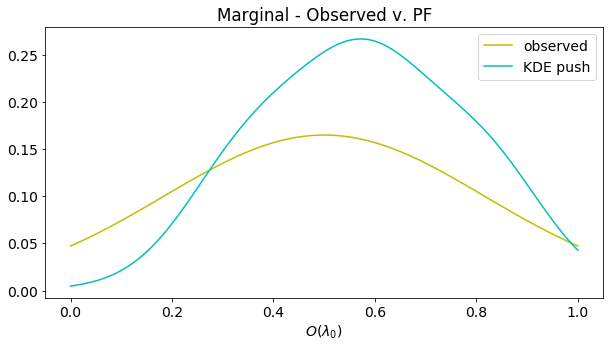

In [47]:
push_post_dens_kde = gkde([D[k][accept_inds] for k in range(output_dim)])

a, b = 0, 1 # linspace parameters for plotting
plot_grid = np.linspace(a, b, 100)


# diagonal crossection view
interact(compare_output_dens, x = fixed(plot_grid), 
         analytical_dens = fixed(obs_dens), estimated_dens = fixed(push_post_dens_kde), 
         lab_1 = fixed('observed'), lab_2 = fixed('KDE push'), title = fixed('Marginal - Observed v. PF'),
         viewdim = (0, output_dim-1, 1))
plt.show()